# XGBOOST


In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# --- Veri Yükleme ve Ön İşleme ---
df = pd.read_excel('final_dataset.xlsx')

# Modelde kullanmayacağımız sütunlar: Seli ve mccinfo; Tarih sütununu da çıkarıyoruz.
drop_columns = ["Seli", "mccinfo", "Tarih"]
df_preprocessed = df.drop(columns=drop_columns)

# Sayısal veriler içeren fakat string olarak tutulmuş sütunları dönüştürelim.
cols_to_convert = [
    "bıst100_Şimdi", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Şimdi", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Şimdi", "USD_Açılış", "USD_Yüksek", "USD_Düşük"
]

def turkish_str_to_float(x):
    if isinstance(x, str):
        # Binlik ayıracını kaldır, ondalık ayracı noktaya çevir.
        x = x.replace('.', '').replace(',', '.')
    try:
        return float(x)
    except:
        print("erro")

for col in cols_to_convert:
    df_preprocessed[col] = df_preprocessed[col].apply(turkish_str_to_float)

# Kategorik değişkenler: "Şehir" ve "İlçe" sütunlarını one-hot encoding uygulayarak dönüştürelim.
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["Şehir", "İlçe"], drop_first=True)


# Hedef ve özelliklerin ayrılması
target_col = "Tek Çekim Komisyon Oranı (Güncel)"
X = df_preprocessed.drop(columns=[target_col])
y = df_preprocessed[target_col]


In [ ]:

# --- Hiperparametre Ayarlaması ve Model Eğitimi ---
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hiperparametre aralıkları
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

kf_outer = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf_outer, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

print("En iyi hiperparametreler:", grid_search.best_params_)
print("En iyi R2 skoru (GridSearchCV ortalama): {:.4f}".format(grid_search.best_score_))


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
En iyi hiperparametreler: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 0.8}
En iyi R2 skoru (GridSearchCV ortalama): 0.6737


In [13]:
best_pipeline = grid_search.best_estimator_

fold_mae = []
fold_mape = []
fold_r2 = []
all_y_true = np.array([])
all_y_pred = np.array([])

fold_idx = 1
kf_manual = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf_manual.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    
    mae_fold = mean_absolute_error(y_test, y_pred)
    mape_fold = mean_absolute_percentage_error(y_test, y_pred)
    r2_fold = r2_score(y_test, y_pred)
    
    fold_mae.append(mae_fold)
    fold_mape.append(mape_fold)
    fold_r2.append(r2_fold)
    
    print(f"Fold {fold_idx} - MAE: {mae_fold:.4f}, MAPE: {mape_fold:.4f}, R2: {r2_fold:.4f}")
    fold_idx += 1
    
    all_y_true = np.concatenate([all_y_true, y_test.values])
    all_y_pred = np.concatenate([all_y_pred, y_pred])
    
print("\nOrtalama Değerlendirme Metrikleri:")
print(f"MAE: {np.mean(fold_mae):.4f}")
print(f"MAPE: {np.mean(fold_mape):.4f}")
print(f"R2: {np.mean(fold_r2):.4f}")




Fold 1 - MAE: 0.2559, MAPE: 0.0588, R2: 0.7246
Fold 2 - MAE: 0.3043, MAPE: 0.0762, R2: 0.7210
Fold 3 - MAE: 0.3617, MAPE: 0.0913, R2: 0.5482
Fold 4 - MAE: 0.2946, MAPE: 0.0890, R2: 0.7290
Fold 5 - MAE: 0.3577, MAPE: 0.1017, R2: 0.5869
Fold 6 - MAE: 0.2670, MAPE: 0.0628, R2: 0.7372
Fold 7 - MAE: 0.2428, MAPE: 0.0557, R2: 0.7448
Fold 8 - MAE: 0.2761, MAPE: 0.0639, R2: 0.7422
Fold 9 - MAE: 0.2936, MAPE: 0.0770, R2: 0.5363
Fold 10 - MAE: 0.2876, MAPE: 0.0627, R2: 0.6673

Ortalama Değerlendirme Metrikleri:
MAE: 0.2941
MAPE: 0.0739
R2: 0.6737


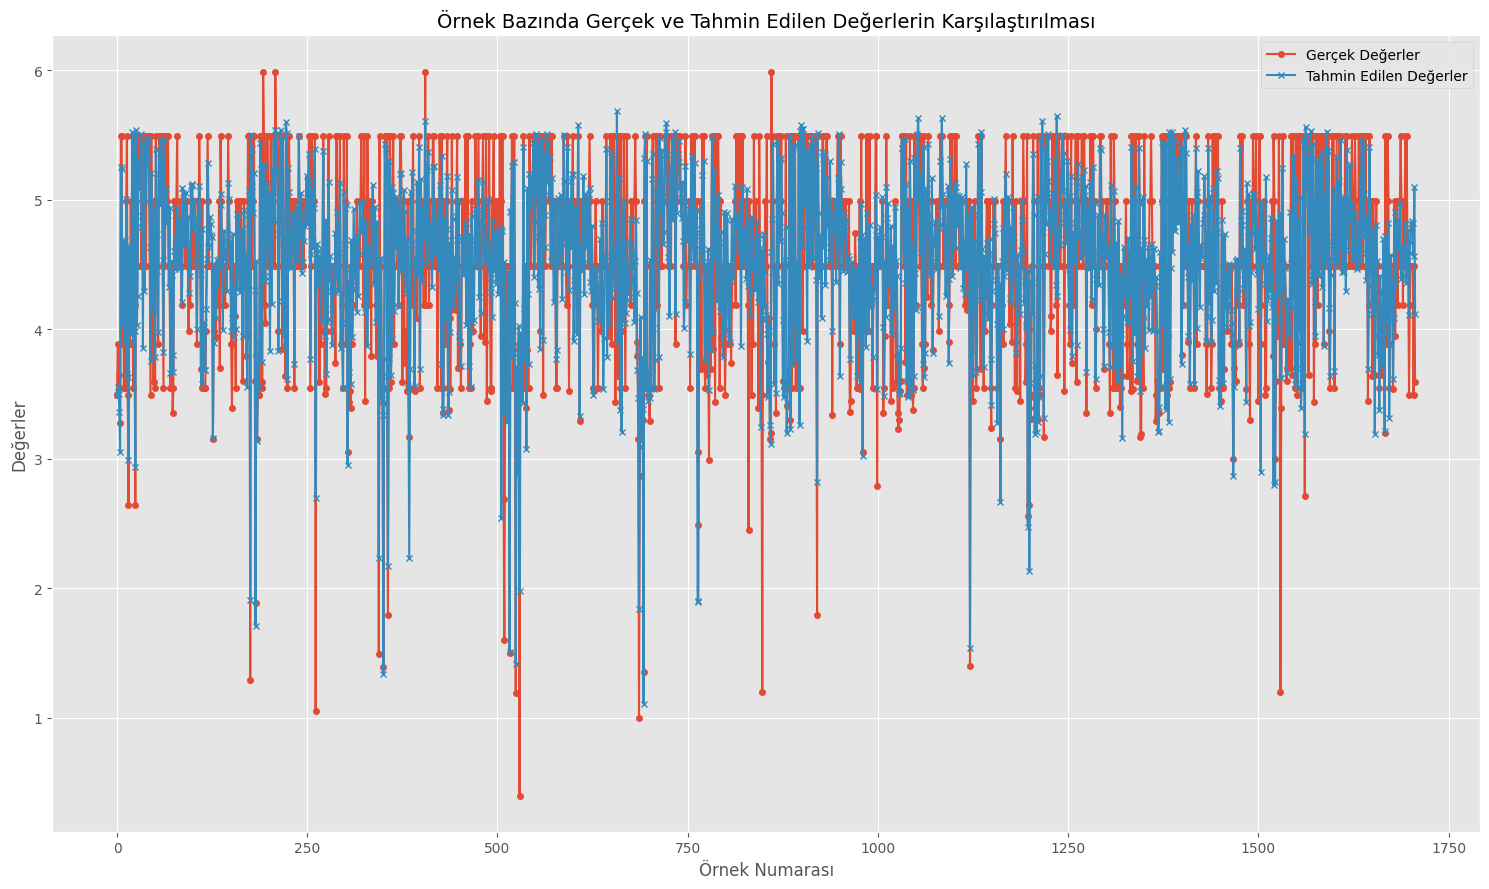

In [14]:
# --- Tahmin ve Gerçek Değerlerin Grafiksel Gösterimi (Örnek Bazında) ---
plt.figure(figsize=(15,9), dpi=100)
# Örnek numarası x ekseninde
sample_index = range(len(all_y_true))

# Gerçek değerler ve tahmin edilen değerleri çiziyoruz.
plt.plot(sample_index, all_y_true, label="Gerçek Değerler", marker='o', linestyle='-', markersize=4)
plt.plot(sample_index, all_y_pred, label="Tahmin Edilen Değerler", marker='x', linestyle='-', markersize=4)

plt.xlabel("Örnek Numarası", fontsize=12)
plt.ylabel("Değerler", fontsize=12)
plt.title("Örnek Bazında Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
all_y_true[0:10]

array([3.49, 3.89, 3.65, 3.55, 3.28, 5.49, 5.49, 3.89, 4.49, 3.55])

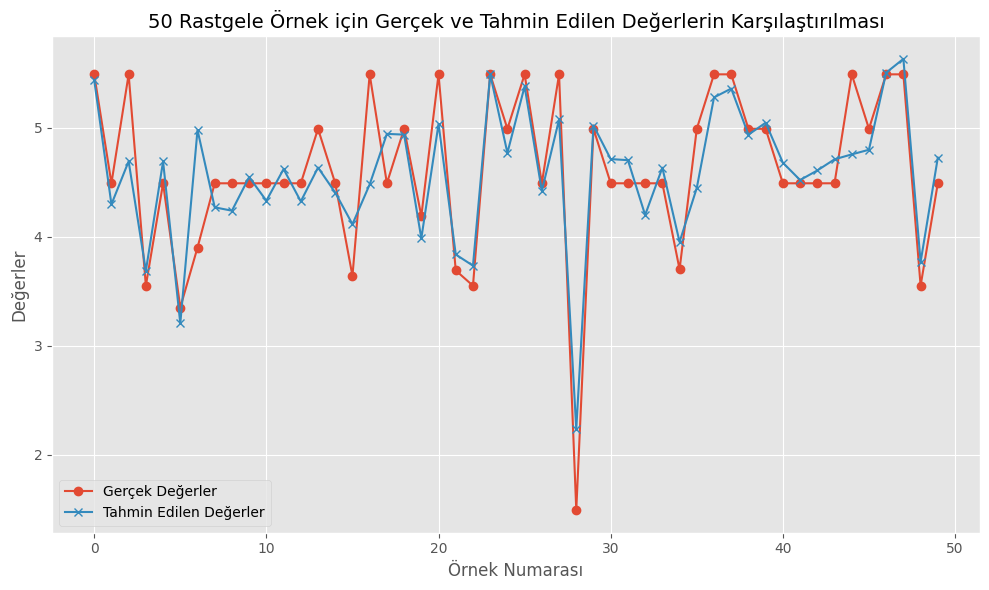

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Rastgele 50 örnek seçmek için indexleri belirleyelim.
np.random.seed(42)  # Tekrar üretilebilir sonuçlar için
total_samples = len(all_y_true)
random_indices = np.random.choice(total_samples, size=50, replace=False)

# Seçilen örnekler için gerçek ve tahmin edilen değerleri alalım.
sample_true = all_y_true[random_indices]
sample_pred = all_y_pred[random_indices]

# Örnek numarasını x ekseni için yeniden oluşturuyoruz (0'dan 49'a kadar).
sample_index = range(len(sample_true))

# Grafik çizimi:
plt.figure(figsize=(10,6))
plt.plot(sample_index, sample_true, label="Gerçek Değerler", marker='o', linestyle='-', markersize=6)
plt.plot(sample_index, sample_pred, label="Tahmin Edilen Değerler", marker='x', linestyle='-', markersize=6)

plt.xlabel("Örnek Numarası", fontsize=12)
plt.ylabel("Değerler", fontsize=12)
plt.title("50 Rastgele Örnek için Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
sample_true

array([5.49, 4.49, 5.49, 3.55, 4.49, 3.35, 3.9 , 4.49, 4.49, 4.49, 4.49,
       4.49, 4.49, 4.99, 4.49, 3.64, 5.49, 4.49, 4.99, 4.19, 5.49, 3.69,
       3.55, 5.49, 4.99, 5.49, 4.49, 5.49, 1.49, 4.99, 4.49, 4.49, 4.49,
       4.49, 3.7 , 4.99, 5.49, 5.49, 4.99, 4.99, 4.49, 4.49, 4.49, 4.49,
       5.49, 4.99, 5.49, 5.49, 3.55, 4.49])

In [28]:
tf = pd.DataFrame({'Gerçek Değerler': sample_true, 'Tahmin Edilen Değerler': sample_pred})

In [29]:
tf

,Gerçek Değerler,Tahmin Edilen Değerler
0,5.49,5.438299
1,4.49,4.296759
2,5.49,4.691730
3,3.55,3.686517
4,4.49,4.690905
5,3.35,3.203454
6,3.90,4.979329
7,4.49,4.269239
8,4.49,4.238484
9,4.49,4.546721
